In [7]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# Define the PINN model
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 256),
            nn.Tanh(),
            nn.Linear(256, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.SiLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        return self.net(X)

def Training_data(u, x_min = -1, x_max = 1, t_min = 0, t_max = 1, N0 = 400, Nb = 400):
  # Initial condition
  x0 = np.random.uniform(x_min, x_max, (N0, 1))
  t0 = np.zeros_like(x0)
  u0_vals = u(x0,t_min)

  # Boundary condition
  tb = np.random.uniform(t_min, t_max, (Nb, 1))
  xb_left = -np.ones_like(tb)  # x = -1
  xb_right = np.ones_like(tb)  # x = 1
  ub_left = u(xb_left, tb)
  ub_right = u(xb_right, tb)

  # Combine for data loss
  x_BC_and_IC = np.vstack([x0, xb_left, xb_right])
  t_BC_and_IC = np.vstack([t0, tb, tb])
  u_BC_and_IC = np.vstack([u0_vals, ub_left, ub_right])

  # Convert to tensors
  x_BC_and_IC = torch.tensor(x_BC_and_IC, dtype=torch.float32, requires_grad=False).to(device)
  t_BC_and_IC = torch.tensor(t_BC_and_IC, dtype=torch.float32, requires_grad=False).to(device)
  u_BC_and_IC = torch.tensor(u_BC_and_IC, dtype=torch.float32).to(device)

  return x_BC_and_IC, t_BC_and_IC, u_BC_and_IC

def boundary_loss(model, x, t, u_true):
    u_pred = model(x, t)
    return torch.mean((u_pred - u_true) ** 2)

def Training_loop(model, optimizer, epochs, boundary_loss, physics_loss, x_BC_and_IC, t_BC_and_IC, u_BC_and_IC,
                  x_min = -1, x_max = 1, t_min = 0, t_max = 1, Nf = 10000):
  # Training loop with tqdm
  pbar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
  for epoch in pbar:
      optimizer.zero_grad()
      if epoch%100 == 0:
        # Resample new collocation points every epoch
        x_f_np = np.random.uniform(x_min, x_max, (Nf, 1))
        t_f_np = np.random.uniform(t_min, t_max, (Nf, 1))
        x_f = torch.tensor(x_f_np, dtype=torch.float32, requires_grad=True).to(device)
        t_f = torch.tensor(t_f_np, dtype=torch.float32, requires_grad=True).to(device)


      # Compute losses
      loss_u = boundary_loss(model, x_BC_and_IC, t_BC_and_IC, u_BC_and_IC)
      loss_f = physics_loss(model, x_f, t_f)
      loss = 10*loss_u + loss_f

      loss.backward()
      optimizer.step()

      # Update progress bar with the latest loss values
      if epoch%100 == 0:
          pbar.set_postfix(Total_Loss=loss.item(), Data_Loss=loss_u.item(), Physics_Loss=loss_f.item())

def plot_PINN(u, model, title, x_min = -1, x_max = 1, t_min = 0, t_max = 1):
  # Plotting prediction heatmap
  x_vals = np.linspace(x_min, x_max, 256)
  t_vals = np.linspace(t_min, t_max, 100)
  X, T = np.meshgrid(x_vals, t_vals)
  X_tensor = torch.tensor(X.flatten(), dtype=torch.float32).view(-1, 1).to(device)
  T_tensor = torch.tensor(T.flatten(), dtype=torch.float32).view(-1, 1).to(device)

  with torch.no_grad():
      U_pred = model(X_tensor, T_tensor).cpu().numpy()

  U = U_pred.reshape(T.shape)

  # Compute true solution
  X_np = X.flatten().reshape(-1, 1)
  T_np = T.flatten().reshape(-1, 1)
  U_true = u(X_np, T_np).reshape(T.shape)

  # Compute error
  Error = np.abs(U - U_true)

  # Plot comparison
  fig, axs = plt.subplots(1, 3, figsize=(18, 4))

  # PINN prediction
  im0 = axs[0].imshow(U, extent=[x_min, x_max, t_min, t_max], origin='lower', aspect='auto', cmap='jet')
  axs[0].set_title("PINN Prediction")
  axs[0].set_xlabel('x')
  axs[0].set_ylabel('t')
  fig.colorbar(im0, ax=axs[0])

  # True solution
  im1 = axs[1].imshow(U_true, extent=[x_min, x_max, t_min, t_max], origin='lower', aspect='auto', cmap='jet')
  axs[1].set_title("True Solution")
  axs[1].set_xlabel('x')
  axs[1].set_ylabel('t')
  fig.colorbar(im1, ax=axs[1])

  # Absolute error
  im2 = axs[2].imshow(Error, extent=[x_min, x_max, t_min, t_max], origin='lower', aspect='auto', cmap='magma')
  axs[2].set_title("Absolute Error")
  axs[2].set_xlabel('x')
  axs[2].set_ylabel('t')
  fig.colorbar(im2, ax=axs[2])

  # Overall figure title
  fig.suptitle(title, fontsize=14, y=1.05)

  plt.tight_layout()
  plt.show()


# Unsteady Heat Diffusion Problem with Dirichlet Boundary Conditions:

Training Progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]

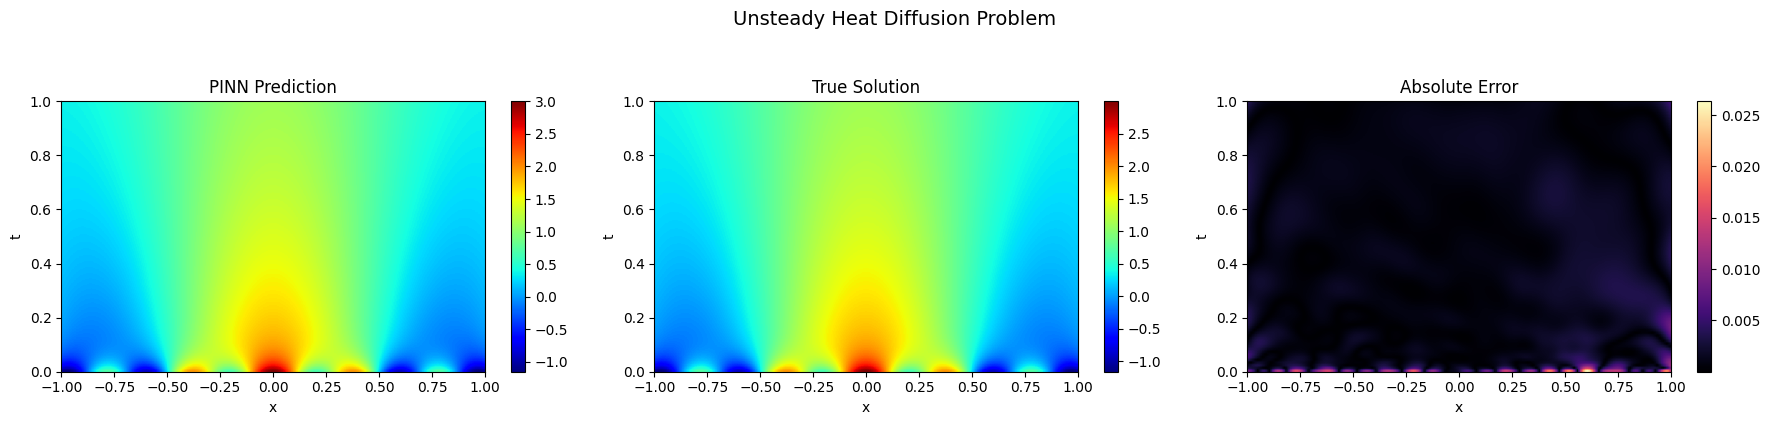

In [9]:
epsilon = 0.1
a = [1,1,1]
alpha = [1,4,16]

# Define true solution
def u(x,t):
  return np.exp(-epsilon*alpha[0]**2*t)*a[0]*np.cos(alpha[0]*x) + np.exp(-epsilon*alpha[1]**2*t)*a[1]*np.cos(alpha[1]*x) + np.exp(-epsilon*alpha[2]**2*t)*a[2]*np.cos(alpha[2]*x)

x_BC_and_IC, t_BC_and_IC, u_BC_and_IC = Training_data(u)

# Initialize model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss functions
def physics_loss(model, x_f, t_f):
    u = model(x_f, t_f)
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = u_t -epsilon * u_xx
    return torch.mean(f**2)

epochs = 5000
Training_loop(model, optimizer, epochs, boundary_loss, physics_loss, x_BC_and_IC, t_BC_and_IC, u_BC_and_IC)

plot_PINN(u, model, "Unsteady Heat Diffusion Problem")

# Unsteady Advection Problem

Training Progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]

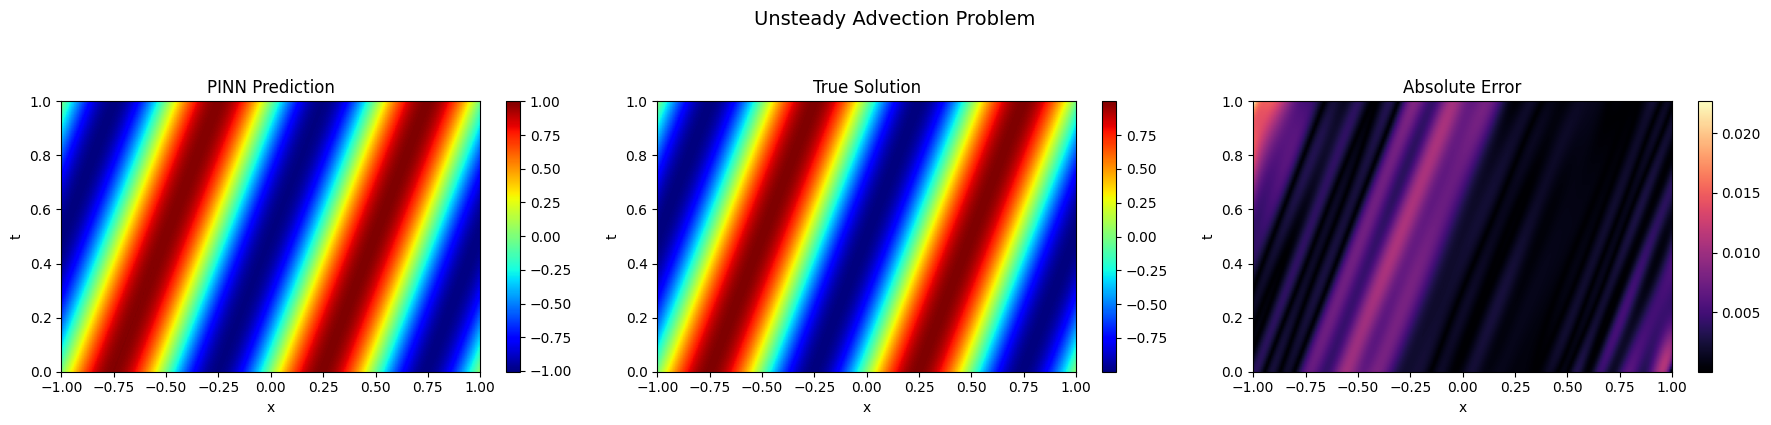

In [10]:
# Define true solution
def f(x):
    return np.sin(2*np.pi*x)
a = 0.5

def u(x,t):
    return f(x-a*t)
x_BC_and_IC, t_BC_and_IC, u_BC_and_IC = Training_data(u)

# Initialize model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def physics_loss(model, x_f, t_f):
    u = model(x_f, t_f)
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    f = u_t + a*u_x
    return torch.mean(f**2)

epochs = 5000
Training_loop(model, optimizer, epochs, boundary_loss, physics_loss, x_BC_and_IC, t_BC_and_IC, u_BC_and_IC)

plot_PINN(u, model, "Unsteady Advection Problem")

# Viscous Burgers Equation

Training Progress:   0%|          | 0/5000 [00:00<?, ?epoch/s]

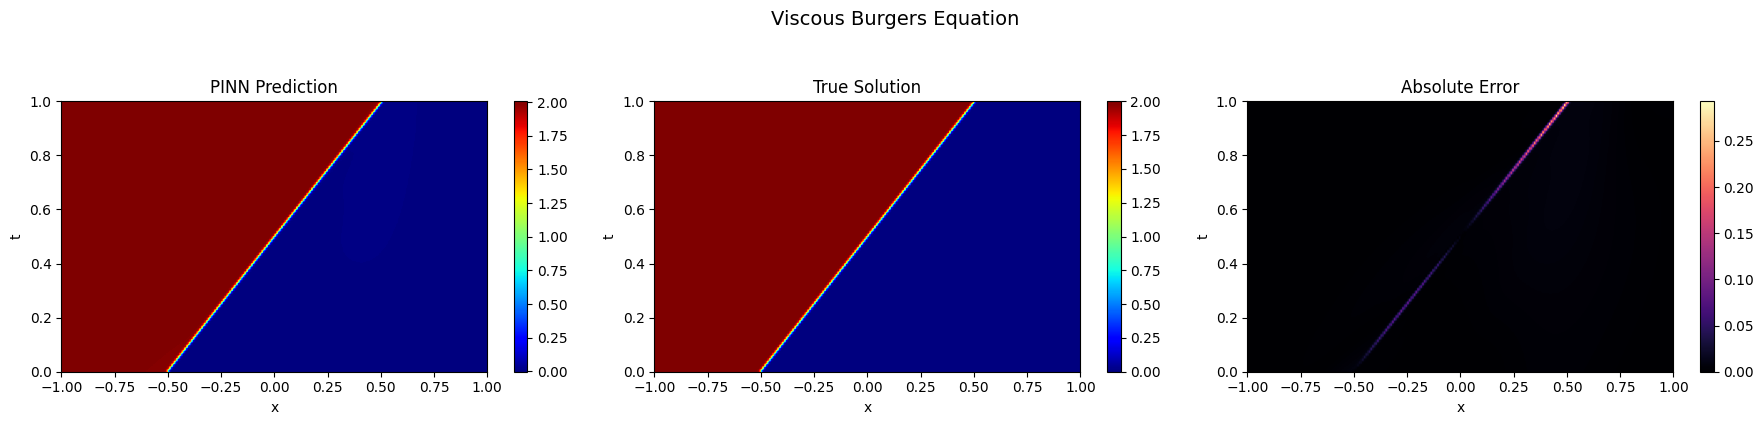

In [11]:
# Set viscosity
nu = 0.01 / np.pi
 
# Define true solution
def u(x, t):
    return -np.tanh((x + 0.5 - t) / (2 * nu)) + 1

x_BC_and_IC, t_BC_and_IC, u_BC_and_IC = Training_data(u)

# Initialize model
model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def physics_loss(model, x_f, t_f):
    u = model(x_f, t_f)
    u_x = torch.autograd.grad(u, x_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t_f, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    f = u_t + u * u_x - nu * u_xx
    return torch.mean(f**2)

epochs = 5000
Training_loop(model, optimizer, epochs, boundary_loss, physics_loss, x_BC_and_IC, t_BC_and_IC, u_BC_and_IC)
plot_PINN(u, model, "Viscous Burgers Equation")